In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import time
import random

In [ ]:
#Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# Your Google Drive is mounted to the VM associated with this notebbok, so that 
# you can access dazta stored in your drive space
# Athentification required 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

# DATA MODEL & PREPARATION

In [ ]:
class TimesSeries(Dataset):

  TRAIN_Percentage= 0.8
  VAL_Percentage= 0.1
  SEQ_len= 100
  scaler = StandardScaler()
  fit=None

  def __init__(self,csv_file,phase):
    super().__init__()    
    self.phase=phase  

    if phase=='train':
      print(f"====== Phase = {self.phase} ====== ")
      self.size= int(len(self.data_df) * self.TRAIN_Percentage)
      self.raw_data=self.data_df[0:self.size]
      self.raw_data = self.scaler.fit_transform(self.raw_data)
      TimesSeries.fit=True
      print("DONE")
    elif phase=='val' and self.VAL_Percentage >0 :
      print(f"====== Phase = {self.phase} ====== ")
      size= int(len(self.data_df) * self.VAL_Percentage)
      val_delimiter=int(len(self.data_df) * self.TRAIN_Percentage)
      self.raw_data=self.data_df[val_delimiter:val_delimiter+size]
      if self.fit:
        print("DONE")
        self.raw_data = self.scaler.transform(self.raw_data)
    elif phase=='test':
      print(f"====== Phase = {self.phase} ====== ")
      size= int(len(self.data_df) * (1-self.TRAIN_Percentage-self.VAL_Percentage))
      val_delimiter=int(len(self.data_df) * (self.TRAIN_Percentage+self.VAL_Percentage))
      self.raw_data=self.data_df[val_delimiter:]
      if self.fit:
        print("DONE")
        self.raw_data = self.scaler.transform(self.raw_data)

    print(f"Data size = {self.raw_data.shape} ")

    self.data_x, self.data_y = self.create_seq(self.raw_data, self.SEQ_len)
    self.size= len(self.data_x)
    print(f"After SEQ data size = {self.data_x.shape} ")
    
  @staticmethod
  def create_seq(data, seq_length):
    x=[]
    y=[]
    for i in range(len(data)-seq_length):
      x_i=data[i:i+seq_length]
      y_i=data[i+1:i+seq_length+1]
      x.append(x_i)
      y.append(y_i)
    return np.array(x),np.array(y)

  @staticmethod
  def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})

  @classmethod
  def inverse_transform(cls, df, columns):
    if cls.fit:
      for col in columns:
          df[col] = cls.scaler.inverse_transform(df[col])
    else:
      print("ERROR : Scaler not fitted yet")
    return df
  
  @classmethod   
  def read_data(cls,csv_file):
    cls.data_df_raw = pd.read_csv(csv_file)
    #cls.data_df_raw=cls.data_df_raw.set_index('date')
    cls.data_df_raw=cls.data_df_raw[cls.data_df_raw['date'] >= '2014' ]
    cls.data_df = cls.data_df_raw.iloc[:,[1]].values

  @classmethod 
  def plot_time_series(cls):
    cls.data_df_raw.plot(kind='line',y=cls.data_df_raw.columns[1],x=cls.data_df_raw.columns[0],color='red',figsize =(11,4))
    plt.show()

  def plot_sequence(self,i):
    plt.figure(figsize=(6,4))
    plt.suptitle(" Sequence %d." % i )
    plt.xlabel("Time Bars")
    plt.ylabel(" Number of passengers")
    plt.plot(range(self.SEQ_len), self.data_x[i], "b-.", label="Feature")
    plt.plot(range(1, self.SEQ_len + 1), self.data_y[i], "r--", label="Target")
    plt.legend()
    plt.show()
    
  def __len__(self):
    return self.size

  def __getitem__(self,idx):
    assert (idx < self.size )," ERROR : getitem:Index out of range "
    return self.data_x[idx], self.data_y[idx]



In [ ]:
BATCH_SIZE =1
NUM_WORKERS =1
FILE_Name ='drive/My Drive/Colab Notebooks/AI_invest_daily.csv' # "monthly-sunspots.csv" #'airline-passengers.csv'

TimesSeries.read_data(FILE_Name)


In [ ]:
TimesSeries.data_df_raw.head()

,date,investment
2985,2014-01-01T00:00:00Z,194663165.0
2986,2014-01-02T00:00:00Z,135519759.0
2987,2014-01-03T00:00:00Z,4500000.0
2988,2014-01-04T00:00:00Z,250000.0
2989,2014-01-05T00:00:00Z,349085.0


In [ ]:

series_datasets = {x: TimesSeries(csv_file=FILE_Name,phase=x)
                                  
                  for x in ['train','val','test']}

dataloaders = {x: torch.utils.data.DataLoader(series_datasets[x], 
                                              batch_size=BATCH_SIZE,
                                              shuffle=False, 
                                              num_workers=NUM_WORKERS)
              for x in ['train','val','test']}

dataset_sizes = {x: len(series_datasets[x]) for x in ['train', 'val','test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using device', device)

====== Phase = train ====== 
DONE
Data size = (1645, 1) 
After SEQ data size = (1545, 100, 1) 
====== Phase = val ====== 
DONE
Data size = (205, 1) 
After SEQ data size = (105, 100, 1) 
====== Phase = test ====== 
DONE
Data size = (206, 1) 
After SEQ data size = (106, 100, 1) 
Using device cuda:0


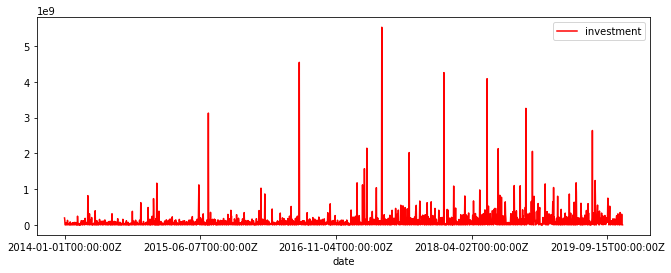

In [ ]:
TimesSeries.plot_time_series()

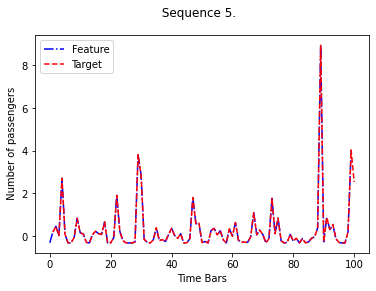

In [ ]:
series_datasets['test'].plot_sequence(5)


# **LSTM MODEL**

In [ ]:
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,seq_len):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = 3
        self.seq_len = seq_len
        
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,num_layers=self.num_layers, batch_first=True,dropout=0.3)
        self.linear = nn.Linear(self.seq_len*self.hidden_size, self.seq_len*self.output_size)
        

    def forward(self, input):
        h_0 = torch.zeros(self.num_layers,input.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers,input.size(0), self.hidden_size)

        h_t, c_t = self.lstm(input, (h_0, c_0))
        h_t=h_t.reshape(h_t.size(0),-1)
        output = self.linear(h_t).unsqueeze(2)

        """
        h_t, c_t = self.lstm(input, (h_0, c_0))
        output=[]
        for i in range(self.seq_len):
          out=self.linear(h_t[:,i,:])
          #print("  SHAPE OUT ", out.shape)
          output += [out]

        outputs = torch.stack(output, 0).permute(1, 0, 2)
        #output=torch.from_numpy(np.array(output))
        """
        return output


In [ ]:
inp=torch.randn(BATCH_SIZE, TimesSeries.SEQ_len, 1)

In [ ]:
model=Model(1,20,1,TimesSeries.SEQ_len)

In [ ]:
model(inp)

# ML Algorithm

In [ ]:
import time
import random


class Learning:
    
    def __init__(self, model, criterion, optimizer, scheduler, dataloaders):
        self.model = model
        self.criterion= criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataloaders= dataloaders
        self.losses=None
        self.df_results=None
    
    def init_losses(self):
      self.losses={ x: [] for x in ['train','val']}
      self.losses['test']=0

    def train(self,n_epochs,init_loss=True):
      if init_loss:
        best_model=None
        best_val=10000
        self.init_losses()
      for epoch in range(n_epochs):
        start_time = time.time()
        for phase in ['train','val']:
          running_loss = 0
          if phase=='train':            
            self.model.train()
          else:
            self.model.eval()
          
          for nb_batch,(x,y) in enumerate(self.dataloaders[phase]):
            x,y=x.to(torch.float32),y.to(torch.float32)
            self.optimizer.zero_grad()
            with torch.set_grad_enabled(phase=='train'):
              y_pred = self.model(x)
              #print(" y_pred = " , y_pred.shape)
              #print(" y = " , y.shape)
              loss=self.criterion(y_pred,y)
              if phase=='train':
                loss.backward()
                self.optimizer.step()      
            running_loss += loss.item()
    
          running_loss /= nb_batch
          self.losses[phase].append(running_loss)

        elapsed = time.time() - start_time
        if running_loss < best_val:
          best_val=running_loss
          best_model= self.model
        print("Epoch %d Train loss: %.5f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, self.losses['train'][epoch], self.losses['val'][epoch], elapsed))
        self.scheduler.step()
      self.plot_losses()
      self.model= best_model
      return self.model
     

    
    def evaluate(self,model=None):
      if model is None:
        model=self.model
      with torch.no_grad():
        test_loss = 0
        actual, predicted = [], []
        
        for nb_batch,(x,y) in enumerate(self.dataloaders['test']):
          x,y=x.to(torch.float32),y.to(torch.float32)
          y_pred = model(x)
          loss=self.criterion(y_pred,y)
          test_loss += loss.item()
          actual += y[:, -1,:].view(-1).numpy().tolist()
          predicted += y_pred[:, -1,:].view(-1).numpy().tolist()
          #if nb_batch==0:
            #print( "Actual values",actual )
            #print( "Predicted values",predicted )
        test_loss /= nb_batch

      self.losses['test']=test_loss
      self.df_result = TimesSeries.to_dataframe(actual, predicted) 
      self.df_result = TimesSeries.inverse_transform(self.df_result, ['actual', 'predicted'])
      self.plot_results()

    def plot_losses(self):
      for phase in ['train', 'val']:
        plt.plot(self.losses[phase], label= phase+" loss")
        plt.legend()
        plt.title("Losses")

    def plot_results(self):
      self.df_result.plot(figsize=(14, 7))
      print("Test loss = %.4f" % self.losses['test'])

    

# TRAINING

In [ ]:
INPUT_SIZE=1
HIDDEN_SIZE= 20
OUTPUT_SIZE=1
N_EPOCHS=15

Epoch 1 Train loss: 0.77236. Validation loss: 0.75. Elapsed time: 89.91s.
Epoch 2 Train loss: 0.37980. Validation loss: 0.27. Elapsed time: 86.21s.
Epoch 3 Train loss: 0.16380. Validation loss: 0.14. Elapsed time: 83.46s.
Epoch 4 Train loss: 0.08124. Validation loss: 0.10. Elapsed time: 79.67s.
Epoch 5 Train loss: 0.06305. Validation loss: 0.09. Elapsed time: 74.27s.
Epoch 6 Train loss: 0.05783. Validation loss: 0.09. Elapsed time: 71.83s.
Epoch 7 Train loss: 0.05047. Validation loss: 0.07. Elapsed time: 70.67s.
Epoch 8 Train loss: 0.04804. Validation loss: 0.06. Elapsed time: 69.59s.
Epoch 9 Train loss: 0.04350. Validation loss: 0.07. Elapsed time: 68.77s.
Epoch 10 Train loss: 0.04270. Validation loss: 0.06. Elapsed time: 68.08s.
Epoch 11 Train loss: 0.03692. Validation loss: 0.03. Elapsed time: 68.14s.
Epoch 12 Train loss: 0.02823. Validation loss: 0.03. Elapsed time: 67.36s.
Epoch 13 Train loss: 0.02547. Validation loss: 0.03. Elapsed time: 67.66s.
Epoch 14 Train loss: 0.02455. Vali

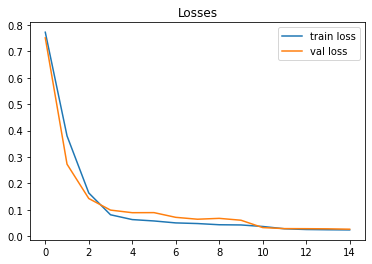

In [ ]:
model = Model(INPUT_SIZE,HIDDEN_SIZE,OUTPUT_SIZE, TimesSeries.SEQ_len) 
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

ML_algo= Learning(model, criterion, optimizer, scheduler, dataloaders)
model=ML_algo.train(N_EPOCHS)


# EVALUATION

Test loss = 0.0452


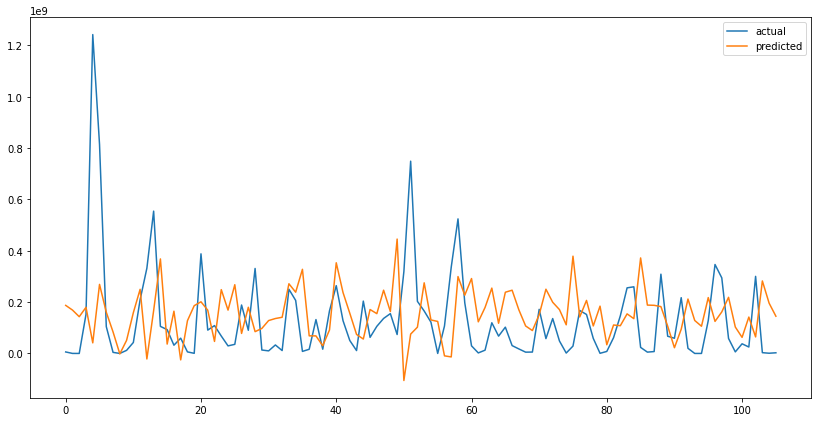

In [ ]:
ML_algo.evaluate(model)

#  Generation

In [ ]:
def generate(model, x_sample,future,df_actual):
  x_tensor= torch.tensor(x_sample.reshape((1,len(x_sample),1)))
  x_tensor=x_tensor.to(torch.float32)
  gen=[]
  model.eval()
  with torch.no_grad():
    for i in range(future):
      y_gen= model(x_tensor)
      y_gen=y_gen[:, -1,:].squeeze()
      gen.append(y_gen)
      new_x= torch.cat([x_tensor.squeeze()[1:],y_gen.unsqueeze(0)])
      x_tensor=new_x.unsqueeze(0).unsqueeze(2)
  gen=TimesSeries.scaler.inverse_transform(gen)
  df=pd.DataFrame({"actual": df_actual[0:future], "generated": gen})
  df.plot(figsize=(14, 7))
  return df

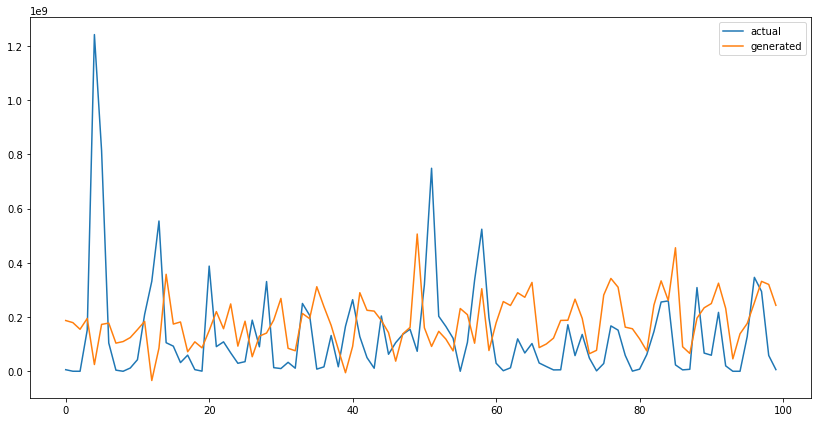

In [ ]:
x_sample= series_datasets['test'].data_x[0].reshape(-1)
future_window=100

df= generate(model, x_sample,future_window,ML_algo.df_result['actual'])

In [ ]:
ML_algo.df_result
from sklearn.metrics import mean_squared_error
import math
mse =mean_squared_error(ML_algo.df_result['actual'], ML_algo.df_result['predicted'])
rmse = math.sqrt(mse)
div=ML_algo.df_result['actual'].max() - ML_algo.df_result['actual'].min()
nrmse = rmse/div
nrmse

0.17217007126401968

In [ ]:
df

,actual,generated
0,5.791397e+06,187100960.0
1,9.999576e+04,179338576.0
2,1.226167e+00,154790944.0
3,1.521658e+08,194771920.0
4,1.241393e+09,24887454.0
...,...,...
95,1.278358e+08,176176864.0
96,3.462380e+08,252770080.0
97,2.942708e+08,331522816.0
98,5.830000e+07,320147232.0


In [ ]:
from sklearn.metrics import mean_squared_error
import math
mse =mean_squared_error(df['actual'], df['generated'])
rmse = math.sqrt(mse)
div=df['actual'].max() - df['actual'].min()
nrmse = rmse/div
nrmse

0.1799385370385872